In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 10})
import matplotlib.cm as cm
import seaborn as sns

import pickle as pkl
from tqdm import tqdm

exec(open("./diagnostics_header.py").read())
import diagnostics_ops as diops
import diagnostics_vars as divars

# -----------------------------------------------------------------

# linestyles list from https://matplotlib.org/gallery/lines_bars_and_markers/linestyles.html
linestyles = [('solid',               (0, ())),
     #('loosely dotted',      (0, (1, 10))),
     #('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     #('loosely dashed',      (0, (5, 10))),
     #('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     #('loosely dashdotted',  (0, (3, 10, 1, 10))),
     #('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     #('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     #('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('solid',               (0, ()))]

In [2]:
save = False
dpi=300

# problem parameters
mach_no = 5
GM1 = 0.7692307692307692
x1min = 0.05
x1max = 0.62              # maximum value of X1
inflow = -0.01            # radial velocity at L1
inflow_dens = 4.0         # density at L1
inflow_phi = 0.05         # angular half-size of the L1 zone
                          # if -n, L1 diameter set to n times thermal scale height
    
inflow_mdot = -np.pi * (x1max*inflow_phi)**2 * inflow_dens * inflow

# time of start of the steady state
tstart_steady = 23.

def state2title (acc_state):
    if acc_state == None:
        return 'steady'
    else:
        return 'state%s' % acc_state

In [3]:
data_pathstem = '/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M5/'
dataset_pathstem = data_pathstem + 'R4_25_v2_wideInfl/'

In [4]:
# pitch angle from the dispersion relation
def omega_binary ():
    return 1.0

def omega_keplerian (r):
    return np.sqrt(GM1)/r**1.5

def tan_pitch (local_mach_no, omega_pattern, omega, m=2):
    return 1. / (local_mach_no * np.sqrt((1.-omega_pattern/omega)**2 - 1./m**2))

def csound_locIsoth (r, mach_no=10.):
    return (np.sqrt(GM1/x1min) / mach_no) * (x1min/r)**(3./8.)

def mach_locIsoth (r, mach_no=10.):
    return np.sqrt(GM1/r) / csound_locIsoth(r, mach_no)

steady


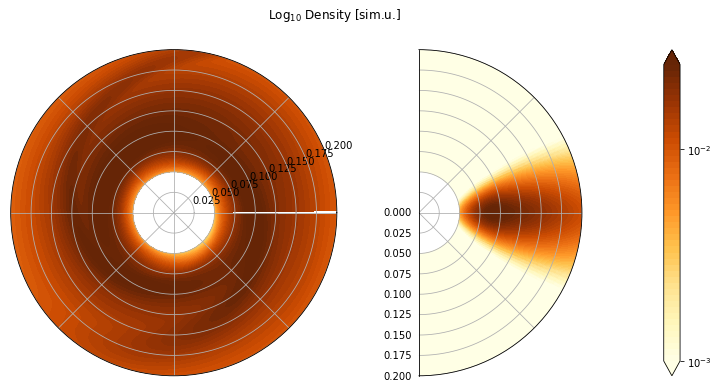

In [5]:
# 2D rho profile

for acc_state in [None,]:
    
    print(state2title(acc_state))

    # load and reuse
    with open(dataset_pathstem + ('%s_rho.pkl' % state2title(acc_state)), 'rb') as f:
        ops_obj_eq, ops_obj_pol = pkl.load(f)

    # plot
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1,3, wspace=0., width_ratios=(1,1,0.05))
    kwargs = {'log_scale':True, 'vmin':0.01, 'vmax':0.25, 'levels':50, 'kwargs':{'cmap':'YlOrBr'}}
    ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[0,0], **kwargs)
    ax.set_ylim(0., 0.2)
    ax, plot = ops_obj_pol.plot(fig, subplot_spec=gs[0,1], **kwargs)
    ax.set_xlim(-0.5*np.pi, 0.5*np.pi)
    ax.set_ylim(0., 0.2)
    plt.subplot(gs[0,2])
    cbar = fig.colorbar(plot, cax=plt.gca(),
                ticks=[-3,-2,-1,0,1])
    cbar.ax.set_yticklabels(['$10^{-3}$', '$10^{-2}$', '$0.1$', '1', '10'])
    plt.suptitle('Log$_{10}$ Density [sim.u.]')
    
    if save:
        plt.savefig('Mach%i_avg_rho_%s.png' % (int(mach_no), state2title(acc_state)), format='png', dpi=dpi)
    else:
        plt.show()
    plt.close()
    
    del ops_obj_eq, ops_obj_pol

In [6]:
with open(dataset_pathstem + 'steady_rho3D.pkl', 'rb') as f:
    data3D = pkl.load(f)

In [7]:
data3D.val.shape

(256, 256, 256)

In [8]:
test = data3D.val[:,128,:]

In [9]:
print(test)

[[0.03683377 0.0373701  0.03803636 ... 0.03498524 0.03559797 0.03622264]
 [0.03883265 0.03945931 0.0401422  ... 0.03697499 0.03767741 0.03828751]
 [0.04047516 0.04115739 0.04180053 ... 0.03859435 0.03931391 0.03985311]
 ...
 [1.5176533  1.2617058  0.1954462  ... 0.00744521 0.02588075 0.16427481]
 [1.8332297  1.123186   0.24829246 ... 0.07330213 0.1569406  0.5009597 ]
 [3.5800967  2.2356641  0.38484374 ... 0.53036886 0.8789113  1.68355   ]]


/home/ppjanka/anaconda3/envs/globAcc/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'nlevels'
  s)


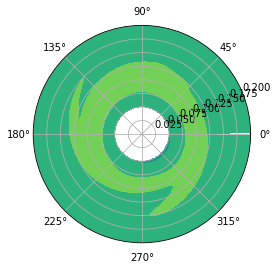

In [10]:
fig = plt.figure()
fig.add_subplot(111, projection='polar')
plt.contourf(data3D.phi, data3D.r, np.log(test), nlevels=50)
plt.ylim(0., 0.2)
plt.show()
plt.close()

In [11]:
# for each phi,r (spherical) pencil, return height R,phi,z (cylindrical) of the highest and lowest density isosurface
def isopoints (level, phi_idx, r_idx, data3D):
    pencil = data3D.val[r_idx, :, phi_idx]
    higher = np.where(pencil > level)[0]
    if len(higher) < 2: return [None, None, None, None]
    theta_idx_min, theta_idx_max = min(higher), max(higher)
    theta_min, theta_max = data3D.theta[theta_idx_min], data3D.theta[theta_idx_max]
    phi = data3D.phi[phi_idx]
    r = data3D.r[r_idx]
    return [r, phi, theta_min, theta_max]

def isosurface (level, data3D):
    idxs_phi, idxs_r = np.meshgrid(range(len(data3D.phi)), range(len(data3D.r)), indexing='ij')
    idxs_phi = idxs_phi.flatten()
    idxs_r = idxs_r.flatten()
    points = map(lambda phi_idx, r_idx : isopoints(level, phi_idx, r_idx, data3D), idxs_phi, idxs_r)
    points = np.array(list(points))
    points = points[points[:,0] != None]
    return np.array(points).transpose().astype(np.float)

In [12]:
print(isopoints(0.05, 128, 10, data3D))

[0.05377732607781681, 3.1538645876571536, 1.4296719170634955, 1.7241925131914184]


In [13]:
blah = isosurface(1., data3D)

In [14]:
blah[0]

array([0.59558662, 0.60246514, 0.6094261 , 0.61647048, 0.55599287,
       0.56239686, 0.56887759, 0.575436  , 0.58207301, 0.58878957,
       0.59558662, 0.60246514, 0.6094261 , 0.61647048, 0.61647048])

Density level: 0.01 sim.u.


/home/ppjanka/anaconda3/envs/globAcc/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

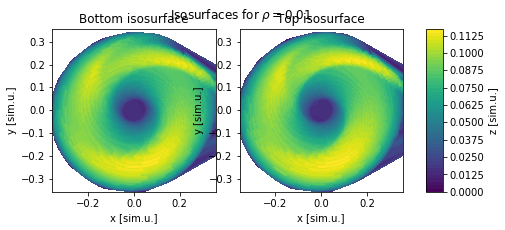

Density level: 0.01 sim.u.


<Figure size 432x288 with 0 Axes>

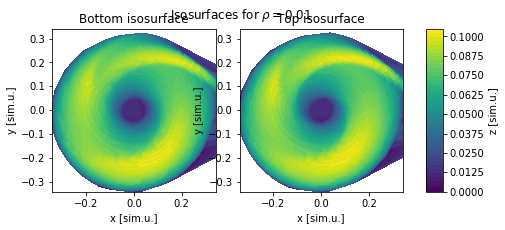

Density level: 0.02 sim.u.


<Figure size 432x288 with 0 Axes>

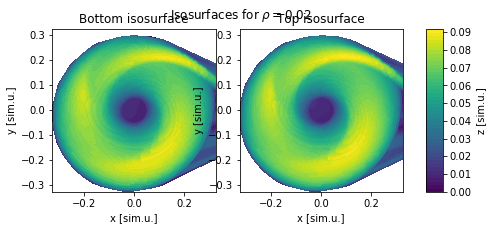

Density level: 0.03 sim.u.


<Figure size 432x288 with 0 Axes>

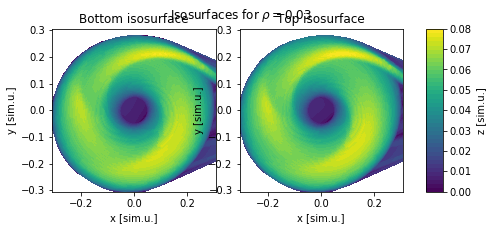

Density level: 0.04 sim.u.


<Figure size 432x288 with 0 Axes>

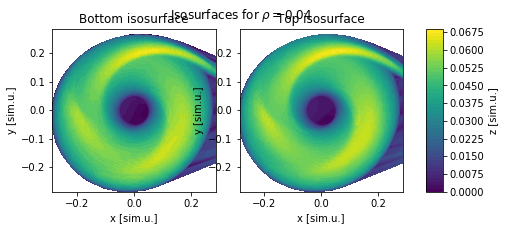

Density level: 0.06 sim.u.


<Figure size 432x288 with 0 Axes>

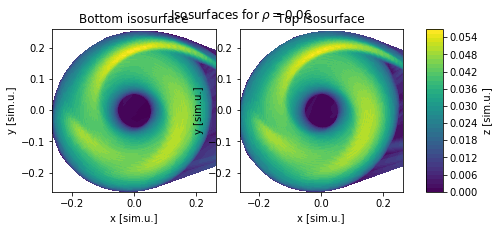

Density level: 0.09 sim.u.


<Figure size 432x288 with 0 Axes>

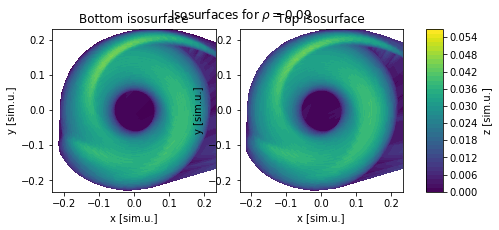

Density level: 0.12 sim.u.


<Figure size 432x288 with 0 Axes>

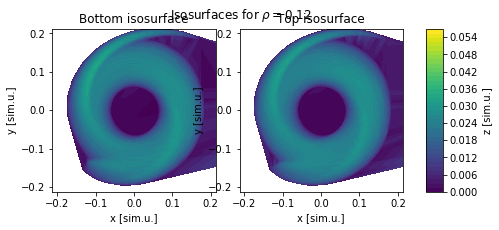

Density level: 0.17 sim.u.


<Figure size 432x288 with 0 Axes>

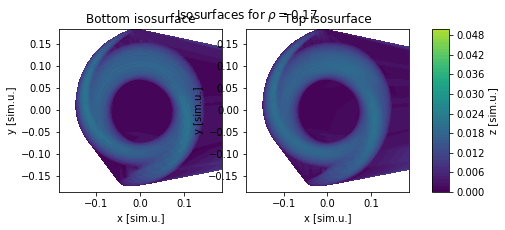

Density level: 0.25 sim.u.


<Figure size 432x288 with 0 Axes>

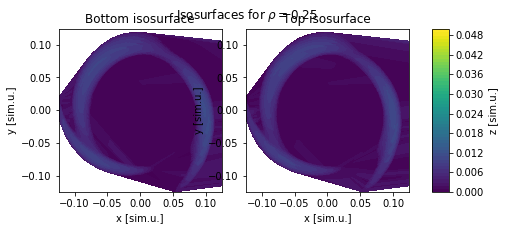

In [15]:
acc_state = None
for logrho_level in np.linspace(-2., np.log10(0.25), 10):
    
    rho_level = 10.**logrho_level
    
    print('Density level: %.2f sim.u.' % rho_level)
    
    # calculate isosurfaces
    blah = isosurface(rho_level, data3D)
    
    # plot

    gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.1])

    plt.clf()
    fig = plt.figure(figsize=[7.,3.])

    theta_min = blah[2] # min
    zmin = np.cos(theta_min) * blah[0]
    xmin = np.sin(theta_min) * blah[0] * np.cos(blah[1])
    ymin = np.sin(theta_min) * blah[0] * np.sin(blah[1])

    theta_max = blah[3] # max
    zmax = np.abs(np.cos(theta_max) * blah[0])
    xmax = np.sin(theta_max) * blah[0] * np.cos(blah[1])
    ymax = np.sin(theta_max) * blah[0] * np.sin(blah[1])

    vmax=max([max(zmin), max(zmax)])
    size = max([abs(min(ymin)), abs(max(ymin)), abs(min(ymax)), abs(max(ymax))])

    plt.subplot(gs[0,0])
    plt.title('Bottom isosurface')
    plt.tricontourf(xmin, ymin, zmin, 50, vmin=0., vmax=vmax)
    plt.subplot(gs[0,1])
    plt.title('Top isosurface')
    sm = plt.tricontourf(xmax, ymax, zmax, 50, vmin=0., vmax=vmax)

    for col in [0,1]:
        plt.subplot(gs[0,col])
        plt.xlim(-size, size)
        plt.ylim(-size, size)
        plt.gca().set_aspect(1.)
        plt.xlabel('x [sim.u.]')
        plt.ylabel('y [sim.u.]')

    plt.subplot(gs[0,2])
    cb = plt.colorbar(sm, cax=plt.gca())
    plt.ylabel('z [sim.u.]')
    plt.suptitle('Isosurfaces for $\\rho=%.2f$' % rho_level)

    if save:
        plt.savefig('Mach%i_isosurf_rho%03i_%s.png' % (int(mach_no), int(100.*rho_level), state2title(acc_state)), format='png', dpi=dpi)
    else:
        plt.show()
    plt.close()